## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import pprint,re, time
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import random
from nltk.tokenize import word_tokenize

#import gzip,os,pickle
#import _pickle as cPickle

import sklearn
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV


#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#samples: each sentence is a list of(word,pos) tuple
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
#Dividing the nltk_data into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:2])

3718
196
[[('Mr.', 'NOUN'), ('Trump', 'NOUN'), ('withdrew', 'VERB'), ('a', 'DET'), ('$', '.'), ('120-a-share', 'ADJ'), ('*U*', 'X'), ('bid', 'NOUN'), ('last', 'ADJ'), ('month', 'NOUN'), ('.', '.')], [('He', 'PRON'), ('and', 'CONJ'), ('other', 'ADJ'), ('critics', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('such', 'ADJ'), ('coaching', 'NOUN'), ('aids', 'NOUN'), ('can', 'VERB'), ('defeat', 'VERB'), ('the', 'DET'), ('purpose', 'NOUN'), ('of', 'ADP'), ('standardized', 'ADJ'), ('tests', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-104', 'X'), ('is', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('gauge', 'VERB'), ('learning', 'NOUN'), ('progress', 'NOUN'), ('.', '.')]]


In [5]:
#converting list of sentences to a list of (word,pos tag) tuples
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
train_tagged_words[:10]

95929


[('Mr.', 'NOUN'),
 ('Trump', 'NOUN'),
 ('withdrew', 'VERB'),
 ('a', 'DET'),
 ('$', '.'),
 ('120-a-share', 'ADJ'),
 ('*U*', 'X'),
 ('bid', 'NOUN'),
 ('last', 'ADJ'),
 ('month', 'NOUN')]

### Exploratory data Analysis

In [6]:
#Unique postags in the corpus
tags = [pair[1] for pair in train_tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [7]:
# tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:20]

['Mr.',
 'Trump',
 'withdrew',
 'a',
 '$',
 '120-a-share',
 '*U*',
 'bid',
 'last',
 'month',
 '.',
 'He',
 'and',
 'other',
 'critics',
 'say',
 '0',
 'such',
 'coaching',
 'aids']

In [8]:
#Most frequent tag in the corpus
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 27509,
         'VERB': 12943,
         'DET': 8333,
         '.': 11137,
         'ADJ': 6097,
         'X': 6314,
         'PRON': 2620,
         'CONJ': 2162,
         'ADP': 9400,
         'PRT': 3059,
         'ADV': 3012,
         'NUM': 3343})

In [9]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NOUN', 27509), ('VERB', 12943), ('.', 11137), ('ADP', 9400), ('DET', 8333)]

In [10]:
# how many words with the tag 'VERB' (verb, past tense) end with 'ed'
past_tense_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.20760256509310052


[('consented', 'VERB'),
 ('subordinated', 'VERB'),
 ('estimated', 'VERB'),
 ('focused', 'VERB'),
 ('gained', 'VERB'),
 ('estimated', 'VERB'),
 ('launched', 'VERB'),
 ('announced', 'VERB'),
 ('included', 'VERB'),
 ('refused', 'VERB'),
 ('recorded', 'VERB'),
 ('consented', 'VERB'),
 ('refused', 'VERB'),
 ('noted', 'VERB'),
 ('formed', 'VERB'),
 ('needed', 'VERB'),
 ('showed', 'VERB'),
 ('cared', 'VERB'),
 ('loved', 'VERB'),
 ('based', 'VERB')]

In [11]:
#how many words with the tag 'VERB' end with 'ing'
participle_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.10793479100672178


[('growing', 'VERB'),
 ('showing', 'VERB'),
 ('according', 'VERB'),
 ('rising', 'VERB'),
 ('being', 'VERB'),
 ('admitting', 'VERB'),
 ('denying', 'VERB'),
 ('saying', 'VERB'),
 ('relating', 'VERB'),
 ('growing', 'VERB'),
 ('holding', 'VERB'),
 ('managing', 'VERB'),
 ('sorting', 'VERB'),
 ('taking', 'VERB'),
 ('curbing', 'VERB'),
 ('turning', 'VERB'),
 ('abolishing', 'VERB'),
 ('championing', 'VERB'),
 ('following', 'VERB'),
 ('booming', 'VERB')]

In [12]:
# what fraction of adjectives ADJ are followed by a noun NOUN 

# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of JJ tags
jj_tags = [t for t in tags if t == 'ADJ']

# create a list of (JJ, NN) tags
jj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(jj_tags))
print(len(jj_nn_tags))
print(len(jj_nn_tags) / len(jj_tags))

6097
4274
0.7010004920452682


In [13]:
#what fraction of determiners DET are followed by a noun NOUN
dt_tags = [t for t in tags if t == 'DET']
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_nn_tags))
print(len(dt_nn_tags) / len(dt_tags))

8333
5328
0.6393855754230169


## Lexical  Model for POS Tagging 

### Lexicon (unigram)

In [14]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.9064672424689277

### POS TAGGING ALGORITHM-- Vanilla viterbi 

In [15]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Mr.',
 'Trump',
 'withdrew',
 'a',
 '$',
 '120-a-share',
 '*U*',
 'bid',
 'last',
 'month']

In [16]:
# vocabulary
V = set(tokens)
print(len(V))

12098


In [18]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [19]:
print(T)

{'NUM', 'X', 'NOUN', 'VERB', 'DET', '.', 'ADJ', 'CONJ', 'PRON', 'ADP', 'PRT', 'ADV'}


#### EMISSION PROBABILITIES

In [20]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [21]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [22]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")



 large
(29, 6097)
(0, 12943)
(0, 27509) 



#### TRANSITION PROBABILITIES

In [23]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [24]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))


(4274, 6097)
(4274, 6097)
(5328, 8333)
(1425, 12943)
(6596, 27509)


In [25]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [26]:
tags_matrix

array([[1.83667362e-01, 2.11187556e-01, 3.53574634e-01, 1.82470828e-02,
        3.58959008e-03, 1.16661683e-01, 3.23063135e-02, 1.37600955e-02,
        1.49566261e-03, 3.49985026e-02, 2.75201909e-02, 2.99132522e-03],
       [2.69242958e-03, 7.49128908e-02, 6.17674999e-02, 2.03515992e-01,
        5.54323718e-02, 1.64079830e-01, 1.69464685e-02, 1.04529615e-02,
        5.70161529e-02, 1.44282550e-01, 1.84035480e-01, 2.48653777e-02],
       [9.23334155e-03, 2.92631499e-02, 2.64240801e-01, 1.46715626e-01,
        1.33774402e-02, 2.39776075e-01, 1.22505361e-02, 4.27132957e-02,
        4.50761570e-03, 1.77178383e-01, 4.39492539e-02, 1.67945027e-02],
       [2.26377193e-02, 2.18341962e-01, 1.10098124e-01, 1.69744268e-01,
        1.33431196e-01, 3.48450914e-02, 6.56725615e-02, 5.56285260e-03,
        3.55404466e-02, 9.11689699e-02, 3.12137827e-02, 8.17430243e-02],
       [2.17208695e-02, 4.59618382e-02, 6.39385581e-01, 4.03216146e-02,
        5.76023059e-03, 1.69206765e-02, 2.03768149e-01, 4.80

In [27]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [28]:
tags_df

,NUM,X,NOUN,VERB,DET,.,ADJ,CONJ,PRON,ADP,PRT,ADV
NUM,0.183667,0.211188,0.353575,0.018247,0.003590,0.116662,0.032306,0.013760,0.001496,0.034999,0.027520,0.002991
X,0.002692,0.074913,0.061767,0.203516,0.055432,0.164080,0.016946,0.010453,0.057016,0.144283,0.184035,0.024865
NOUN,0.009233,0.029263,0.264241,0.146716,0.013377,0.239776,0.012251,0.042713,0.004508,0.177178,0.043949,0.016795
VERB,0.022638,0.218342,0.110098,0.169744,0.133431,0.034845,0.065673,0.005563,0.035540,0.091169,0.031214,0.081743
DET,0.021721,0.045962,0.639386,0.040322,0.005760,0.016921,0.203768,0.000480,0.003720,0.009000,0.000240,0.012721
.,0.080273,0.026398,0.220167,0.089162,0.175541,0.093921,0.044446,0.058454,0.066176,0.090958,0.002335,0.052079
ADJ,0.020338,0.021486,0.701001,0.012465,0.004920,0.064130,0.065934,0.016566,0.000656,0.077907,0.009841,0.004756
CONJ,0.042091,0.008788,0.351526,0.151249,0.120259,0.036540,0.117021,0.000463,0.059204,0.053191,0.005088,0.054579
PRON,0.006870,0.092366,0.208397,0.488550,0.009542,0.039695,0.073282,0.004580,0.007252,0.022137,0.012595,0.034733
ADP,0.062447,0.034574,0.322340,0.008404,0.323511,0.039255,0.107447,0.000851,0.069043,0.017021,0.001383,0.013723


In [29]:
tags_df.loc['.', :]

NUM     0.080273
X       0.026398
NOUN    0.220167
VERB    0.089162
DET     0.175541
.       0.093921
ADJ     0.044446
CONJ    0.058454
PRON    0.066176
ADP     0.090958
PRT     0.002335
ADV     0.052079
Name: ., dtype: float32

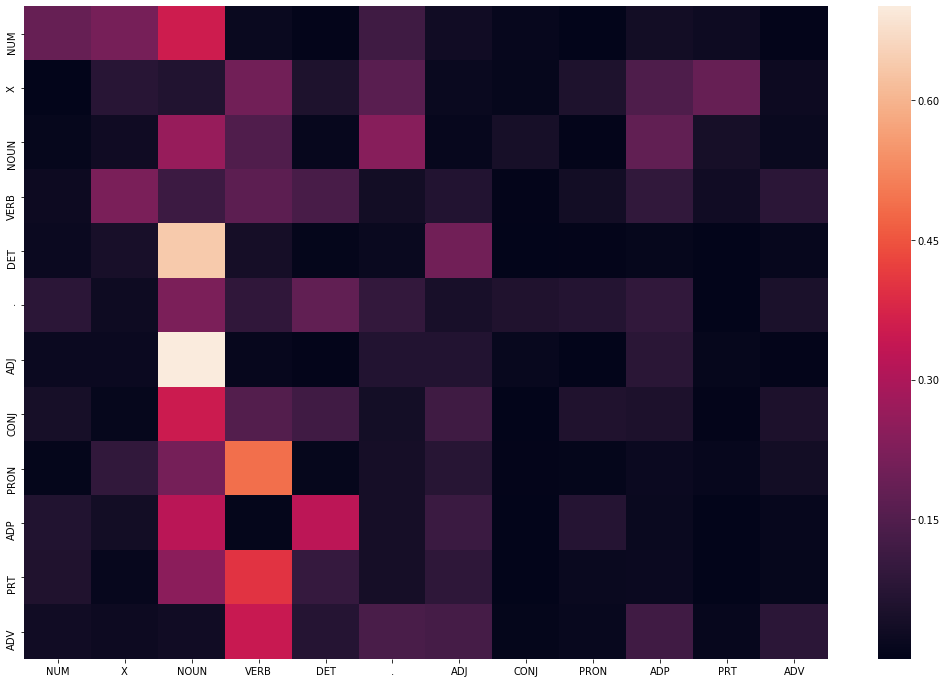

In [30]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


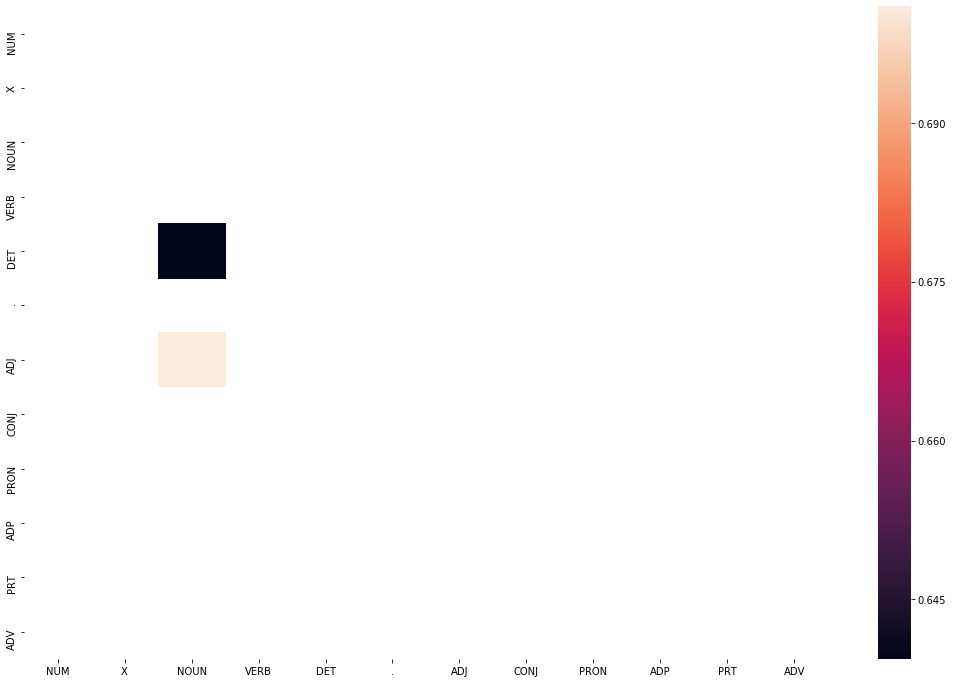

In [31]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [32]:
len(train_tagged_words)

95929

In [33]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on test set

In [34]:

# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('March', 'NOUN'),
  ('and', 'CONJ'),
  ('May', 'NOUN'),
  ('contracts', 'NOUN'),
  ('rose', 'VERB'),
  ('to', 'PRT'),
  ('fresh', 'ADJ'),
  ('life-of-contract', 'ADJ'),
  ('highs', 'NOUN'),
  ('of', 'ADP'),
  ('14.54', 'NUM'),
  ('cents', 'NOUN'),
  ('and', 'CONJ'),
  ('14.28', 'NUM'),
  ('cents', 'NOUN'),
  ('at', 'ADP'),
  ('their', 'PRON'),
  ('best', 'ADJ'),
  ('levels', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('day', 'NOUN'),
  ('.', '.')],
 [('In', 'ADP'),
  ('the', 'DET'),
  ('1970s', 'NUM'),
  (',', '.'),
  ('scientists', 'NOUN'),
  ('reported', 'VERB'),
  ('cancer', 'NOUN'),
  ('cases', 'NOUN'),
  ('among', 'ADP'),
  ('the', 'DET'),
  ('daughters', 'NOUN'),
  ('of', 'ADP'),
  ('DES', 'NOUN'),
  ('users', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('rights', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-173', 'X'),
  ('expire', 'VERB'),
  ('Nov.', 'NOUN'),
  ('21', 'NUM'),
  (',', '.'),
  ('can', 'VERB'),
  ('be', 'VERB'),
  ('exercised', 'VERB'

In [35]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [36]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  34.408474922180176
[('The', 'DET'), ('March', 'NOUN'), ('and', 'CONJ'), ('May', 'NOUN'), ('contracts', 'NOUN'), ('rose', 'VERB'), ('to', 'PRT'), ('fresh', 'ADJ'), ('life-of-contract', 'NUM'), ('highs', 'NOUN'), ('of', 'ADP'), ('14.54', 'NUM'), ('cents', 'NOUN'), ('and', 'CONJ'), ('14.28', 'NUM'), ('cents', 'NOUN'), ('at', 'ADP'), ('their', 'PRON'), ('best', 'ADJ'), ('levels', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('day', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('the', 'DET'), ('1970s', 'NUM'), (',', '.'), ('scientists', 'NOUN'), ('reported', 'VERB'), ('cancer', 'NOUN'), ('cases', 'NOUN'), ('among', 'ADP'), ('the', 'DET'), ('daughters', 'NOUN'), ('of', 'ADP'), ('DES', 'NOUN'), ('users', 'NOUN'), ('.', '.'), ('The', 'DET'), ('rights', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-173', 'NUM'), ('expire', 'VERB'), ('Nov.', 'NOUN'), ('21', 'NUM'), (',', '.'), ('can', 'VERB'), ('be', 'VERB'), ('exercised', 'VERB'), ('*-104', 'NUM'), ('for', 'ADP'), ('$', '.'), ('100', '

In [37]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [38]:
viterbi_accuracy = len(check)/len(tagged_seq)

In [39]:
viterbi_accuracy

0.9047619047619048

In [40]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [41]:
incorrect_tagged_cases

[[('fresh', 'ADJ'),
  (('life-of-contract', 'NUM'), ('life-of-contract', 'ADJ'))],
 [('which', 'DET'), (('*T*-173', 'NUM'), ('*T*-173', 'X'))],
 [('exercised', 'VERB'), (('*-104', 'NUM'), ('*-104', 'X'))],
 [('a', 'DET'), (('subject', 'ADJ'), ('subject', 'NOUN'))],
 [('read', 'VERB'), (('Mickey', 'NUM'), ('Mickey', 'NOUN'))],
 [('Mickey', 'NOUN'), (('Spillane', 'NUM'), ('Spillane', 'NOUN'))],
 [('about', 'ADP'), (('Groucho', 'NUM'), ('Groucho', 'NOUN'))],
 [('and', 'CONJ'), (('Harpo', 'NUM'), ('Harpo', 'NOUN'))]]

In [42]:
## Testing
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [43]:
print(tagged_seq)
print(difference)

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.'), ('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.'), ('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [44]:
viterbi_test_tagged_seq = tagged_seq

### Models 

### Rule based tagging

#### Regular Expression Based Chunking

In [45]:
pattern = [
     (r'.*ing$', 'VERB'),                # gerunds
     (r'.*ed$', 'VERB'),                 # simple past
     (r'.*es$', 'VERB'),                 # 3rd singular present
     
     (r'.*\'s$', 'NOUN'),                # possessive nouns
     (r'.*s$', 'NOUN'),                  # plural nouns
     (r'^-?[0-9]+(\.[0-9]+)?$', 'NUM'),  # cardinal numbers
     (r'.*', 'NOUN')                      # nouns (default)
 ]

In [49]:
def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]


### Probabilistic Models 

### Modifying verterbi algorithm 

In [50]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [51]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

life-of-contract
NOUN
14.54
NUM
14.28
NUM
*T*-173
NOUN
*-104
NOUN
Mickey
NOUN
Spillane
NOUN
Groucho
NOUN
Harpo
NOUN
Time taken in seconds:  30.180667638778687
[('The', 'DET'), ('March', 'NOUN'), ('and', 'CONJ'), ('May', 'NOUN'), ('contracts', 'NOUN'), ('rose', 'VERB'), ('to', 'PRT'), ('fresh', 'ADJ'), ('life-of-contract', 'NOUN'), ('highs', 'NOUN'), ('of', 'ADP'), ('14.54', 'NUM'), ('cents', 'NOUN'), ('and', 'CONJ'), ('14.28', 'NUM'), ('cents', 'NOUN'), ('at', 'ADP'), ('their', 'PRON'), ('best', 'ADJ'), ('levels', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('day', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('the', 'DET'), ('1970s', 'NUM'), (',', '.'), ('scientists', 'NOUN'), ('reported', 'VERB'), ('cancer', 'NOUN'), ('cases', 'NOUN'), ('among', 'ADP'), ('the', 'DET'), ('daughters', 'NOUN'), ('of', 'ADP'), ('DES', 'NOUN'), ('users', 'NOUN'), ('.', '.'), ('The', 'DET'), ('rights', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-173', 'NOUN'), ('expire', 'VERB'), ('Nov.', 'NOUN'), ('21', 'NUM'), (',',

In [52]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(modified_viterbi_accuracy)

0.9523809523809523


In [53]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('fresh', 'ADJ'),
  (('life-of-contract', 'NOUN'), ('life-of-contract', 'ADJ'))],
 [('which', 'DET'), (('*T*-173', 'NOUN'), ('*T*-173', 'X'))],
 [('exercised', 'VERB'), (('*-104', 'NOUN'), ('*-104', 'X'))],
 [('a', 'DET'), (('subject', 'ADJ'), ('subject', 'NOUN'))]]

In [54]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NOUN
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('mad

In [55]:
## version  2

In [56]:
def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [57]:
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [58]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

life-of-contract
NOUN
14.54
NUM
14.28
NUM
*T*-173
NOUN
*-104
NOUN
Mickey
NOUN
Spillane
NOUN
Groucho
NOUN
Harpo
NOUN
Time taken in seconds:  30.0580792427063
[('The', 'DET'), ('March', 'NOUN'), ('and', 'CONJ'), ('May', 'NOUN'), ('contracts', 'NOUN'), ('rose', 'VERB'), ('to', 'PRT'), ('fresh', 'ADJ'), ('life-of-contract', 'NOUN'), ('highs', 'NOUN'), ('of', 'ADP'), ('14.54', 'NUM'), ('cents', 'NOUN'), ('and', 'CONJ'), ('14.28', 'NUM'), ('cents', 'NOUN'), ('at', 'ADP'), ('their', 'PRON'), ('best', 'ADJ'), ('levels', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('day', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('the', 'DET'), ('1970s', 'NUM'), (',', '.'), ('scientists', 'NOUN'), ('reported', 'VERB'), ('cancer', 'NOUN'), ('cases', 'NOUN'), ('among', 'ADP'), ('the', 'DET'), ('daughters', 'NOUN'), ('of', 'ADP'), ('DES', 'NOUN'), ('users', 'NOUN'), ('.', '.'), ('The', 'DET'), ('rights', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-173', 'NOUN'), ('expire', 'VERB'), ('Nov.', 'NOUN'), ('21', 'NUM'), (',', '

In [59]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_accuracy = len(check)/len(tagged_seq)
print(lexicon_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9523809523809523


[[('fresh', 'ADJ'),
  (('life-of-contract', 'NOUN'), ('life-of-contract', 'ADJ'))],
 [('which', 'DET'), (('*T*-173', 'NOUN'), ('*T*-173', 'X'))],
 [('exercised', 'VERB'), (('*-104', 'NOUN'), ('*-104', 'X'))],
 [('a', 'DET'), (('subject', 'ADJ'), ('subject', 'NOUN'))]]

In [60]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NOUN
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('mad

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [61]:
print("Vannila Viterbi Accuracy: "+ str(viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9047619047619048
Lexicon Based Viterbi Accuracy: 0.9523809523809523
Rule Based Viterbi Accuracy: 0.9523809523809523


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### 1) Using rule_based modified viterbi , the words like Google, Android, Twitter which were tagged as num earlier are modified to NOUN

### 2) The Verbs which were mistagged were corrected

### 3) Words ending with -ing, -ed were tagged as VERB using Rule Based modified viterbi

### 4) The integers , numbers are tagged to NUM